In [1]:
import numpy as np
import constraints
import constants as c
import sid
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import standardmodel as sm
import darksector as ds
import pickle
from scipy import integrate
from matplotlib.ticker import FuncFormatter

In [16]:
ms = 100*10**-6
theta = 10**0
print((constraints.decay_rate_3nu(ms, theta)*c.MeVtoHz)**-1/(14*10**9*np.pi*10**7))
#print in scinetific notation
print((constraints.decay_rate_nu_photon(ms, theta)*c.MeVtoHz))


9942397.249571957
1.7927519820439954e-27


# Check some numbers

Self-interacting DM constraints

In [2]:
# Convert SIDM bound into MeV
bound = 0.1/(c.gtoMeV*c.inversecmtoMeV**2) # in MeV^-3
mN2 = 1 #MeV
gphi_over_gf_bound = np.sqrt(4*np.pi*bound/(mN2*c.Gf**2))
# Write the bound in scientific notation
print("{:.2e}".format(gphi_over_gf_bound))

2.13e+08


Heavy Mediator

In [3]:
# Just check some numbers in the scaling relation
1/(c.Gf*10**8)

888.9335405483592

2 to 4 conversion processes

In [13]:
# Just check some numbers in the scaling relation
temp=1000
gstar=100
beta=10**-4
phase_space=1
# Before thermalization
print((np.sqrt(8*np.pi*gstar/3)*temp**-7/(0.03*3*c.Gf**4*c.mplanck*beta*phase_space))**(1./4))
# After thermalization
print((np.sqrt(8*np.pi*gstar/3)*temp**-7/(0.03*3*c.Gf**4*c.mplanck*phase_space))**(1./4)*(0.5*beta)**(-7./16))

63.69546809388745
485.0752952203439


2 to 2 conversion processes

In [20]:
temp=100
gstar=100
beta=10**-4
(8*np.pi*gstar/3)**(1./4)*temp**-(3./2)*(0.03*c.mplanck*beta*c.Gf**2)**-0.5

2.4998180611966467

Decay lifetimes

In [5]:
# For scalar-mediated decay of the heavy sterile. Lower bound of the lifetime (ignore time dilation)
ms = 1 #MeV
lifetime = 1/(c.MeVtoHz*c.Gf**2*ms**5/(192*np.pi**3))
print(f"Lifetime (s) = {lifetime} s")

Lifetime (s) = 30963.304995128743 s


# Chemical Equilibrium in the sterile sector

In [3]:
def beta(theta, ms):
    return 10**-3*(theta**2*10**12)*ms

def gamma_s_2to2(beta, Gphi_over_Gf, temp, p):
    return beta*0.03*(Gphi_over_Gf*c.Gf)**2*temp**4*p

def gamma_s_2to4(beta, gphi_over_gf, temp, p, phase_space_ratio=1):
    return phase_space_ratio*(Gphi_over_Gf*c.Gf)**2*temp**4*gamma_s_2to2(beta, Gphi_over_Gf, temp, p)

def min_Gphi_ratio_chemical_eq(ms, theta):
    """The minimum G_\phi/G_F ratio for chemical equilibrium to be maintained via 2 to 4 processes"""
    return (ds.hubble_rate_func(sid.Tmax(ms))/(beta(theta, ms)*sid.Tmax(ms)**9*c.Gf**4))**(1./4)

def min_Gphi_ratio_2to2(ms, theta, p='default', temp='default', flavor='electron'):
    """The minimum G_\phi/G_F ratio for \Gamma_s(2to2) > \Gamma_a: ie, for sterile neutrino scattering to be 
    relevant for the production of sterile neutrinos"""
    if temp == 'default':
        temp = sid.Tmax(ms)
    if p == 'default':
        p = sid.Tmax(ms)
    return np.sqrt(sid.active_scattering_rate(p, temp, flavor, False)/(0.03*beta(theta, ms)*c.Gf**2*temp**4*p))


print(min_Gphi_ratio_chemical_eq(1, 10**-5))
print(f"Mass -5/6 scaling check, should decrease 10x: {min_Gphi_ratio_chemical_eq(10**(6./5), 10**-5)}")
print(f"Theta -1/2 scaling check, should decrease 10x: {min_Gphi_ratio_chemical_eq(1, 10**-3)}")

3.312115788213123
Mass -5/6 scaling check, should decrease 10x: 0.334134594811443
Theta -1/2 scaling check, should decrease 10x: 0.33121157882131236


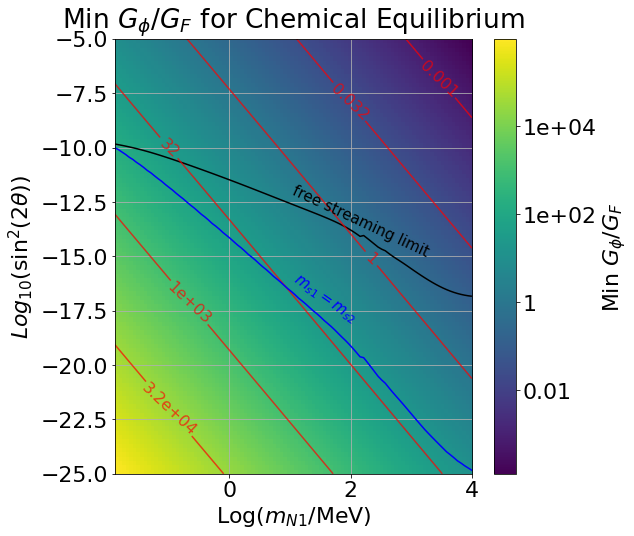

In [8]:
# Load the constraints
ms1_dense = np.loadtxt('data/results_plot_data/ms1_dense.txt')
log_sinsq2theta_equal = np.loadtxt('data/results_plot_data/log_sinsq2theta_equal.txt')
X = np.loadtxt('data/results_plot_data/X.txt')
Y = np.loadtxt('data/results_plot_data/Y.txt')
ms2_required = np.loadtxt('data/results_plot_data/ms2_required.txt')

plt.figure(figsize=(8,8))

# Plot ms1=ms2 constraint
plt.plot(np.log10(ms1_dense), log_sinsq2theta_equal, c='b')
plt.annotate(r'$m_{s1}=m_{s2}$', (1, -18), fontsize=15, c='b', rotation=-35)

# Plot fs constraints
fs_limit = 9.7  # keV: from Nadler et. al. 2021
contours = plt.contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid', levels=[np.log10(fs_limit)])
plt.annotate('free streaming limit', (1, -15), fontsize=15, c='k', rotation=-25)

# Plot using imshow
min_Gphi_over_Gf = min_Gphi_ratio_chemical_eq(10**X, np.sqrt((10**Y))/2.)

# Make sure extent matches X and Y range, and set aspect to 'auto'
im = plt.imshow(np.log10(min_Gphi_over_Gf), origin='lower', aspect='auto',
                     extent=[X.min(), X.max(), Y.min(), Y.max()])

# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(min_Gphi_over_Gf), colors='red', linestyles='solid', alpha=0.7)
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'Min $G_\phi/G_F$')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.title(r'Min $G_\phi/G_F$ for Chemical Equilibrium')
plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.grid()
plt.show()


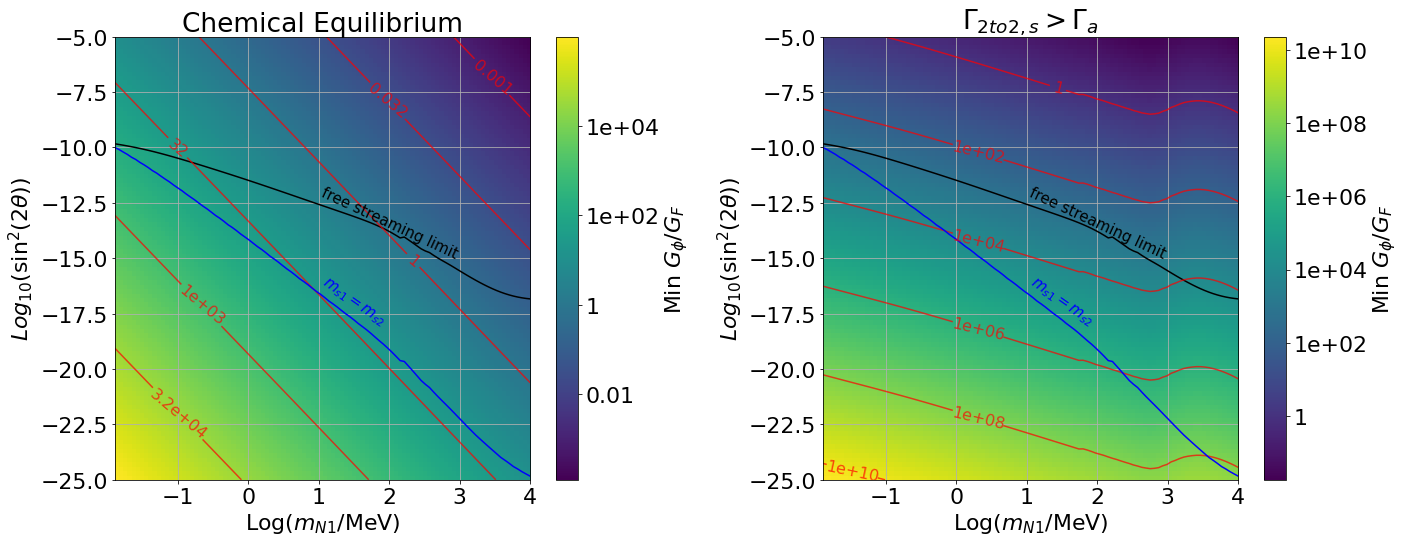

In [27]:
# Load the constraints
ms1_dense = np.loadtxt('data/results_plot_data/ms1_dense.txt')
log_sinsq2theta_equal = np.loadtxt('data/results_plot_data/log_sinsq2theta_equal.txt')
X = np.loadtxt('data/results_plot_data/X.txt')
Y = np.loadtxt('data/results_plot_data/Y.txt')
ms2_required = np.loadtxt('data/results_plot_data/ms2_required.txt')

fig, ax = plt.subplots(1, 2, figsize=(20,8))
vmin, vmax = 10**-3, 10**8
# -------------------------- First Plot -------------------------------------
# Plot ms1=ms2 constraint for ax[0]
ax[0].plot(np.log10(ms1_dense), log_sinsq2theta_equal, c='b')
ax[0].annotate(r'$m_{s1}=m_{s2}$', (1, -18), fontsize=15, c='b', rotation=-35)

# Plot fs constraints for ax[0]
fs_limit = 9.7  # keV: from Nadler et. al. 2021
contours0 = ax[0].contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid', levels=[np.log10(fs_limit)])
ax[0].annotate('free streaming limit', (1, -15), fontsize=15, c='k', rotation=-25)

# Plot using imshow for ax[0]
min_Gphi_over_Gf = min_Gphi_ratio_chemical_eq(10**X, np.sqrt((10**Y))/2.)
im0 = ax[0].imshow(np.log10(min_Gphi_over_Gf), origin='lower', aspect='auto',
                   extent=[X.min(), X.max(), Y.min(), Y.max()])

# Make all the contour lines solid for ax[0]
contours_red0 = ax[0].contour(X, Y, np.log10(min_Gphi_over_Gf), colors='red', linestyles='solid', alpha=0.7)
ax[0].clabel(contours_red0, inline=True, fontsize=16, fmt=FuncFormatter(format_func))

ax[0].set_title(r'Chemical Equilibrium')
ax[0].set_xlabel(r'Log($m_{N1}$/MeV)')
ax[0].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
ax[0].grid()


# Colorbar for the first plot (ax[0])
cb0 = fig.colorbar(im0, ax=ax[0], orientation='vertical')
cb0.set_label(r'Min $G_\phi/G_F$')
cb0.formatter = FuncFormatter(format_func)
cb0.update_ticks()

# -------------------------- Second Plot -------------------------------------
# Plot ms1=ms2 constraint for ax[1]
ax[1].plot(np.log10(ms1_dense), log_sinsq2theta_equal, c='b')
ax[1].annotate(r'$m_{s1}=m_{s2}$', (1, -18), fontsize=15, c='b', rotation=-35)

# Plot fs constraints for ax[1]
contours1 = ax[1].contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid', levels=[np.log10(fs_limit)])
ax[1].annotate('free streaming limit', (1, -15), fontsize=15, c='k', rotation=-25)

# Plot using imshow for ax[1]
min_Gphi_over_Gf_2to2 = min_Gphi_ratio_2to2(10**X, np.sqrt((10**Y))/2.)
im1 = ax[1].imshow(np.log10(min_Gphi_over_Gf_2to2), origin='lower', aspect='auto',
                   extent=[X.min(), X.max(), Y.min(), Y.max()])

# Make all the contour lines solid for ax[1]
contours_red1 = ax[1].contour(X, Y, np.log10(min_Gphi_over_Gf_2to2), colors='red', linestyles='solid', alpha=0.7)
ax[1].clabel(contours_red1, inline=True, fontsize=16, fmt=FuncFormatter(format_func))

ax[1].set_title(r'$\Gamma_{2to2,s} > \Gamma_a$')
ax[1].set_xlabel(r'Log($m_{N1}$/MeV)')
ax[1].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
ax[1].grid()

# Colorbar for the second plot (ax[1])
cb1 = fig.colorbar(im1, ax=ax[1], orientation='vertical')
cb1.set_label(r'Min $G_\phi/G_F$')
cb1.formatter = FuncFormatter(format_func)
cb1.update_ticks()

plt.tight_layout()
plt.show()

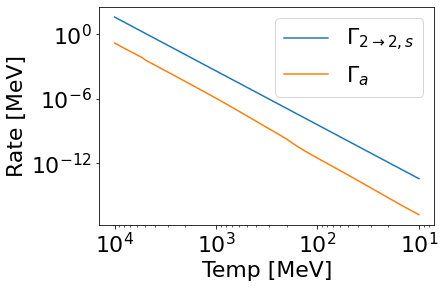

In [6]:
# When is 2 to 2 sterile scattering greater than active neutrino scattering?
ms = 10**-2
theta = 10**-3
Gphi_over_Gf = 10**2
T_domain = np.logspace(4,1, 100)
p_domain = T_domain # Doesn't matter because both linearly depend on T

plt.loglog(T_domain, gamma_s_2to2(beta(theta, ms), Gphi_over_Gf, T_domain, p_domain), label=r'$\Gamma_{2\rightarrow 2, s}$')
plt.loglog(T_domain, sid.active_scattering_rate(p_domain, T_domain, 'electron', False), label=r'$\Gamma_{a}$')
plt.ylabel('Rate [MeV]')
plt.xlabel("Temp [MeV]")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

# Are any SM lifetimes an issue?

In [2]:
def age_of_universe_upper_bound(T_SM, g_min):
    """In 1/MeV"""
    return np.sqrt(3/(32*np.pi*c.grav*g_min))*T_SM**-2

def total_decay_lifetime(inverse_branching_ratio, ms, theta):
    """In 1/MeV"""
    return (inverse_branching_ratio*constraints.decay_rate_3nu(ms, theta))**-1

def min_sinsqtheta_to_ignore_SM(inverse_branching_ratio, ms, SM_over_DS_temp, g_min):
    T_SM = SM_over_DS_temp*ms
    return (age_of_universe_upper_bound(T_SM, g_min)*inverse_branching_ratio*ms**5*c.Gf**2/(192*np.pi**3))**-1


print(age_of_universe_upper_bound(10000, 10.)/c.MeVtoHz, " age of the universe upper bound in seconds")
print('{:.2e}'.format(total_decay_lifetime(20., 10000, 10**-5)/c.MeVtoHz), "time until annihilation in seconds")
print('{:.2e}'.format(min_sinsqtheta_to_ignore_SM(20., 10**4, 0.1, 10.)), "minimum sin^2(theta) to ignore SM")

4.386603799795809e-09  age of the universe upper bound in seconds
1.55e-07 time until annihilation in seconds
3.53e-11 minimum sin^2(theta) to ignore SM


# Check the SM lifetime of $m_{s1}$

In [4]:
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)
ms1_values = data_dict['ms1_values']
sinsq2theta_values = data_dict['sinsq2theta_values']
a_domain = data_dict['a_domain']
T_SM_domain = data_dict['T_SM_domain']

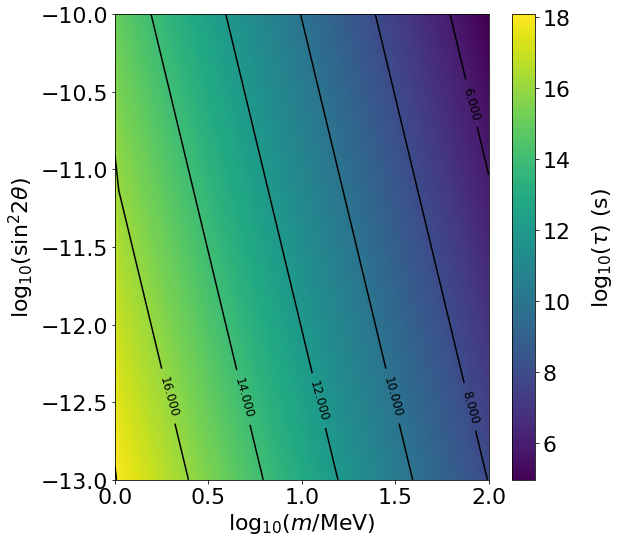

In [6]:
ms1_dense = np.logspace(np.log10(ms1_values[0]), np.log10(ms1_values[-1]), 100)
sinsq2theta_dense = np.logspace(np.log10(sinsq2theta_values[0]), np.log10(sinsq2theta_values[-1]), 90)

x, y = np.meshgrid(ms1_dense, sinsq2theta_dense)
log_lifetimes = np.log10(1/(constraints.total_decay_rate(x, np.arcsin(np.sqrt(y))/2.)*c.MeVtoHz))

plt.figure(figsize=(9,8))

# Swap x and y in imshow
im = plt.imshow(log_lifetimes, origin='lower', extent=[np.log10(x[0][0]), np.log10(x[-1][-1]), np.log10(y[0][0]), np.log10(y[-1][-1])], aspect='auto')
cb = plt.colorbar(im)
cb.set_label(r"$\log_{10}(\tau)$ (s)", labelpad=20)

# Swap x and y in contour
contours = plt.contour(np.log10(x), np.log10(y), log_lifetimes, colors='k')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=12)

# Swap labels
plt.xlabel(r'$\log_{10}(m$/MeV)')
plt.ylabel(r'$\log_{10}(\sin^2 2\theta)$')

plt.tight_layout()
plt.show()

Expanded domains

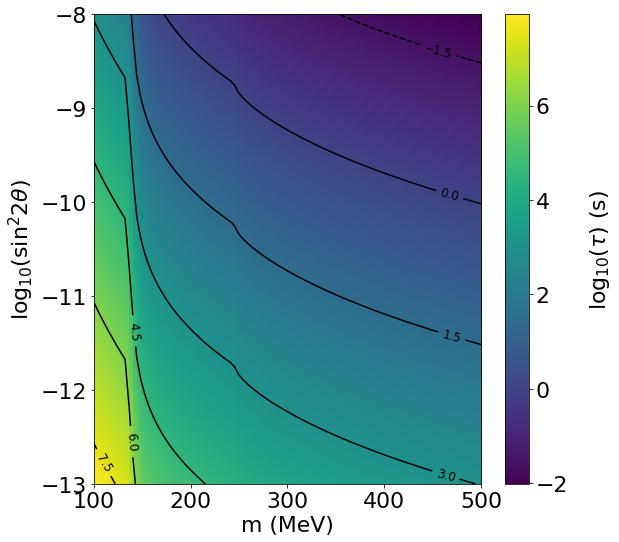

In [19]:
ms1_dense = np.linspace(100, 500, 100)
sinsq2theta_dense = np.logspace(-13, -8, 90)

x, y = np.meshgrid(ms1_dense, sinsq2theta_dense)
log_lifetimes = np.log10(1/(constraints.total_decay_rate(x, np.arcsin(np.sqrt(y))/2.)*c.MeVtoHz))

plt.figure(figsize=(9,8))

# Swap x and y in imshow
im = plt.imshow(log_lifetimes, origin='lower', extent=[x[0][0], x[-1][-1], np.log10(y[0][0]), np.log10(y[-1][-1])], aspect='auto')
cb = plt.colorbar(im)
cb.set_label(r"$\log_{10}(\tau)$ (s)", labelpad=20)

# Swap x and y in contour
contours = plt.contour(x, np.log10(y), log_lifetimes, colors='k')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=12)

# Swap labels
plt.xlabel(r'm (MeV)')
plt.ylabel(r'$\log_{10}(\sin^2 2\theta)$')

plt.tight_layout()
plt.show()
